This data loads the data sets, applies quality cuts, and saves them together as galaxy objects for use in other notebooks. I save a large training set for template training, and a validation set for photo-z estimation. Afterward, I make some plots to characterize the data set.

NOTE that eventually this notebook should completely replace the readme in the data folder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split
import pickle

from modules import Galaxy, get_bandpass_dict, get_eff_wavelen

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

## **Load the Bandpasses**

In [3]:
bandpass_dict = get_bandpass_dict(dlambda=1)

In [4]:
print("{:<9}{:>9}{:>9}".format("Filter","lambda0","Weff"))
for name in bandpass_dict:
    band = bandpass_dict[name]
    print("{:<9}{:>9.1f}{:>9.1f}".format(name,band.eff_wavelen,band.eff_width))

Filter     lambda0     Weff
NUV         2343.1    767.3
u           3817.7    525.4
Bcfh12k     4342.5    873.6
B           4478.4    763.9
g+          4808.5   1043.1
g           4899.9   1293.8
Vcfh12k     5393.7    882.7
V           5493.0    862.4
r           6278.2   1120.2
r+          6314.8   1211.4
Rcfh12k     6603.5   1138.5
i2          7584.5   1409.4
i           7676.6   1307.6
i+          7709.1   1361.7
Icfh12k     8277.3   1816.7
z           8857.6   1040.1
z+          9054.5   1012.3
y          10216.0    996.2
J          12508.5   1476.8


## **Loading and trimming the data set**

Load the data sets, and apply quality cuts. I also throw out any galaxy not observed in the i band, because I will use this for normalization, and the magnitude prior. Might do something more sophisticated later.

### *Zhou et al. catalog*

This catalog consists of CFHTLS/Subaru photometry paired with DEEP2/3 and HST spec-z's. The catalog is described in [Zhou et al.](https://doi.org/10.1093/mnras/stz1866), and the data can be downloaded [here](http://d-scholarship.pitt.edu/36064/).
Only the most secure redshifts are kept (z quality $\geq$ 3 for DEEP2/3; z quality $=$ 1 for HST), and all [SExtractor flags](https://sextractor.readthedocs.io/en/latest/Flagging.html) are required to be < 4. We throw out saturated, masked or blended objects and objects identified as stars by CFHTLS by requiring the CFHTLS flag = 1. We also throw out any objects without "class" = GALAXY.

#### Deep2/3 catalog

In [5]:
cat = Table.read("data/DEEP2_uniq_Terapix_Subaru_v1.fits")
print("The Deep2/3 catalog contains",len(cat),"objects")

# quality cuts on data
uflag  = cat['u(sexflag)']
gflag  = cat['g(sexflag)']
rflag  = cat['r(sexflag)']
i2flag = cat['i2(sexflag)']
iflag  = cat['i(sexflag)']
zflag  = cat['z(sexflag)']
yflag  = cat['y(sexflag)']
cflag  = cat['flag_cfhtls']
zqual  = cat['zquality']
Class  = cat['class']

S = 4 # SExtractor flag

idx = np.where( (  uflag < S ) &
                (  gflag < S ) &
                (  rflag < S ) &
                ( i2flag < S ) &
                (  iflag < S ) &
                (  zflag < S ) &
                (  yflag < S ) &
                ( cflag == 0 ) &
                ( zqual >= 3 ) &
                ( Class == 'GALAXY' ) )

cat = cat[idx]
print("After quality cuts, we have",len(cat),"objects")

# get the data
redshift  = cat['zhelio']

u  = cat['u_apercor']
g  = cat['g_apercor']
r  = cat['r_apercor']
i2 = cat['i2_apercor']
i  = cat['i_apercor']
z  = cat['z_apercor']
y  = cat['y_apercor']

uerr  = np.sqrt( cat['uerr_aper']**2  +  cat['uerr_apercor']**2 )
gerr  = np.sqrt( cat['gerr_aper']**2  +  cat['gerr_apercor']**2 )
rerr  = np.sqrt( cat['rerr_aper']**2  +  cat['rerr_apercor']**2 )
i2err = np.sqrt( cat['i2err_aper']**2 + cat['i2err_apercor']**2 )
ierr  = np.sqrt( cat['ierr_aper']**2  +  cat['ierr_apercor']**2 )
zerr  = np.sqrt( cat['zerr_aper']**2  +  cat['zerr_apercor']**2 )
yerr  = np.sqrt( cat['yerr_aper']**2  +  cat['yerr_apercor']**2 )

# save the data
deep_galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([u[j],g[j],r[j],i2[j],i[j],z[j],y[j]])
    errs = np.array([uerr[j],gerr[j],rerr[j],i2err[j],ierr[j],zerr[j],yerr[j]])
    filters = np.array(['u','g','r','i2','i','z','y'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) & ( errs != 0) )
    
    # if the galaxy was observed in zero bands, skip it
    if idx[0].size == 0:
        continue

    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = errs[idx]
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = 'DEEP2/3'
    
    # cut low SN ratios
    SNR = 20
    idx = np.where( galaxy.fluxes/galaxy.flux_err >= SNR )
    galaxy.wavelen = galaxy.wavelen[idx]
    galaxy.mags = galaxy.mags[idx]
    galaxy.mag_err = galaxy.mag_err[idx]
    galaxy.fluxes = galaxy.fluxes[idx]
    galaxy.flux_err = galaxy.flux_err[idx]
    galaxy.filters = galaxy.filters[idx]
        
    if 'i' not in galaxy.filters and 'i2' not in galaxy.filters:
        continue
        
    if galaxy.redshift == 0 or galaxy.filters.size < 3:
        continue
    
    deep_galaxies.append(galaxy)
    
print("After removing objects with no photometry in the i bands, we have",len(deep_galaxies),"objects")

The Deep2/3 catalog contains 23822 objects
After quality cuts, we have 14172 objects
After removing objects with no photometry in the i bands, we have 10695 objects


#### HST catalog

In [6]:
cat = Table.read("data/3D-HST_Terapix_Subaru_v1.fits")
print("The HST catalog contains",len(cat),"objects")

# remove objects that are also in DEEP2/3 catalog
deep2N = cat['objno_deep2']
idx = np.where( deep2N == -99 )
cat = cat[idx]
print("There are",len(cat),"objects that aren't in Deep2/3")

# quality cuts on data
uflag  = cat['u(sexflag)']
gflag  = cat['g(sexflag)']
rflag  = cat['r(sexflag)']
i2flag = cat['i2(sexflag)']
iflag  = cat['i(sexflag)']
zflag  = cat['z(sexflag)']
yflag  = cat['y(sexflag)']
cflag  = cat['flag_cfhtls']
zqual  = cat['use_zgrism1']

S = 4 # SExtractor flag

idx = np.where( (  uflag < S ) &
                (  gflag < S ) &
                (  rflag < S ) &
                ( i2flag < S ) &
                (  iflag < S ) &
                (  zflag < S ) &
                (  yflag < S ) &
                ( cflag == 0 ) &
                ( zqual == 1 ) )

cat = cat[idx]
print("After quality cuts, we have",len(cat),"objects")

# get the data
redshift  = cat['z_max_grism']

u  = cat['u_apercor']
g  = cat['g_apercor']
r  = cat['r_apercor']
i2 = cat['i2_apercor']
i  = cat['i_apercor']
z  = cat['z_apercor']
y  = cat['y_apercor']

uerr  = np.sqrt( cat['uerr_aper']**2  +  cat['uerr_apercor']**2 )
gerr  = np.sqrt( cat['gerr_aper']**2  +  cat['gerr_apercor']**2 )
rerr  = np.sqrt( cat['rerr_aper']**2  +  cat['rerr_apercor']**2 )
i2err = np.sqrt( cat['i2err_aper']**2 + cat['i2err_apercor']**2 )
ierr  = np.sqrt( cat['ierr_aper']**2  +  cat['ierr_apercor']**2 )
zerr  = np.sqrt( cat['zerr_aper']**2  +  cat['zerr_apercor']**2 )
yerr  = np.sqrt( cat['yerr_aper']**2  +  cat['yerr_apercor']**2 )

# save the data
hst_galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([u[j],g[j],r[j],i2[j],i[j],z[j],y[j]])
    errs = np.array([uerr[j],gerr[j],rerr[j],i2err[j],ierr[j],zerr[j],yerr[j]])
    filters = np.array(['u','g','r','i2','i','z','y'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) & ( errs != 0) )
    
    # if the galaxy was observed in zero bands, skip it
    if idx[0].size == 0:
        continue
        
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = errs[idx]
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = '3D-HST'
    
    # cut low SN ratios
    SNR = 20
    idx = np.where( galaxy.fluxes/galaxy.flux_err >= SNR )
    galaxy.wavelen = galaxy.wavelen[idx]
    galaxy.mags = galaxy.mags[idx]
    galaxy.mag_err = galaxy.mag_err[idx]
    galaxy.fluxes = galaxy.fluxes[idx]
    galaxy.flux_err = galaxy.flux_err[idx]
    galaxy.filters = galaxy.filters[idx]
            
    if 'i' not in galaxy.filters and 'i2' not in galaxy.filters:
        continue
        
    if galaxy.redshift == 0 or galaxy.filters.size < 3:
        continue
        
    hst_galaxies.append(galaxy)

print("After removing objects with no photometry in the i bands, we have",len(hst_galaxies),"objects")

The HST catalog contains 14462 objects
There are 12546 objects that aren't in Deep2/3
After quality cuts, we have 1706 objects
After removing objects with no photometry in the i bands, we have 1153 objects


### *COSMOS catalog*

Add more details here

In [7]:
cat = Table.read('data/zcosmost_bright20k.csv',format='csv')
print("The zCOSMOS catalog contains",len(cat),"objects")

idx = np.where( cat['zpec'] > 0 )
cat = cat[idx]
print(len(cat),"objects have redshift > 0")

idx = np.where( cat['id_photzi25'] != 9999999 )
cat = cat[idx]
print("Of these, we have photometry for",len(cat))

# quality cuts on data
idx = np.where(( cat['flag_maskb_photzi25'] == 0 ) &
               ( cat['flag_maskv_photzi25'] == 0 ) &
               ( cat['flag_maski_photzi25'] == 0 ) &
               ( cat['flag_maskz_photzi25'] == 0 ) &
               ( cat['flag_maskd_photzi25'] == 0 ) )

cat = cat[idx]
print("After quality cuts, we have",len(cat),"objects")

# get the data
redshift = cat['zpec']

FUV = cat['fuv_photzi25']
NUV = cat['nuv_photzi25']
u   = cat['u_photzi25']
B   = cat['b_photzi25']
gp  = cat['g_photzi25']
V   = cat['v_photzi25']
rp  = cat['r_photzi25']
i   = cat['ic_photzi25']
ip  = cat['i_photzi25']
zp  = cat['z_photzi25']
J   = cat['j_photzi25']
Ks   = cat['k_photzi25']

FUVerr = cat['efuv_photzi25']
NUVerr = cat['enuv_photzi25']
uerr   = cat['eu_photzi25']
Berr   = cat['eb_photzi25']
gperr  = cat['eg_photzi25']
Verr   = cat['ev_photzi25']
rperr  = cat['er_photzi25']
ierr   = cat['eic_photzi25']
iperr  = cat['ei_photzi25']
zperr  = cat['ez_photzi25']
Jerr   = cat['ej_photzi25']
Kserr   = cat['ek_photzi25']

# save the data
cosmos_galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([NUV[j],u[j],B[j],gp[j],V[j],rp[j],i[j],ip[j],zp[j],J[j]])
    errs = np.array([NUVerr[j],uerr[j],Berr[j],gperr[j],Verr[j],rperr[j],ierr[j],iperr[j],zperr[j],Jerr[j]])
    filters = np.array(['NUV','u','B','g+','V','r+','i','i+','z+','J'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) & ( errs != 0) )
    
    # if the galaxy was observed in zero bands, skip it
    if idx[0].size == 0:
        continue
            
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = np.fabs(errs[idx])
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = 'zCOSMOS'
    
    # cut low SN ratios
    SNR = 20
    idx = np.where( galaxy.fluxes/galaxy.flux_err >= SNR )
    galaxy.wavelen = galaxy.wavelen[idx]
    galaxy.mags = galaxy.mags[idx]
    galaxy.mag_err = galaxy.mag_err[idx]
    galaxy.fluxes = galaxy.fluxes[idx]
    galaxy.flux_err = galaxy.flux_err[idx]
    galaxy.filters = galaxy.filters[idx]
            
    if 'i' not in galaxy.filters and 'i+' not in galaxy.filters:
        continue
        
    if galaxy.redshift == 0 or galaxy.filters.size < 3:
        continue
        
    cosmos_galaxies.append(galaxy)

print("After removing objects with no photometry in the i bands, we have",len(cosmos_galaxies),"objects")

The zCOSMOS catalog contains 17358 objects
16650 objects have redshift > 0
Of these, we have photometry for 16480
After quality cuts, we have 14311 objects
After removing objects with no photometry in the i bands, we have 14298 objects


### *VVDS catalog*

Add more details here

#### VVDS Deep and Ultra-Deep

In [8]:
cat = Table.read('data/vvds_deep_veryreliable.csv',format='csv')
print("The VVDS Deep and Ultra-Deep catalogs contain",len(cat),"objects")

# quality cuts
zflags = cat['ds_spectra.ZFLAGS']
idx = np.where( (zflags == 3) | (zflags == 4))
cat = cat[idx]
print(len(cat),"objects have zflag = 3,4")

# get the data
redshift = cat['ds_spectra.Z']

Bcfh12k = cat['ds_cfh12k.MAG_AUTO_B']
Vcfh12k = cat['ds_cfh12k.MAG_AUTO_V']
Rcfh12k = cat['ds_cfh12k.MAG_AUTO_R']
Icfh12k = cat['ds_cfh12k.MAG_AUTO_I']
u = cat['MAG_AUTO_U']
g = cat['MAG_AUTO_G']
r = cat['MAG_AUTO_R']
i = cat['MAG_AUTO_I']
z = cat['MAG_AUTO_Z']

Bcfh12kerr = cat['ds_cfh12k.MAGERR_AUTO_B']
Vcfh12kerr = cat['ds_cfh12k.MAGERR_AUTO_V']
Rcfh12kerr = cat['ds_cfh12k.MAGERR_AUTO_R']
Icfh12kerr = cat['ds_cfh12k.MAGERR_AUTO_I']
uerr = cat['MAGERR_AUTO_U']
gerr = cat['MAGERR_AUTO_G']
rerr = cat['MAGERR_AUTO_R']
ierr = cat['MAGERR_AUTO_I']
zerr = cat['MAGERR_AUTO_Z']

# save the data
vvdsDeep_galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([Bcfh12k[j],Vcfh12k[j],Rcfh12k[j],Icfh12k[j],u[j],g[j],r[j],i[j],z[j]])
    errs = np.array([Bcfh12kerr[j],Vcfh12kerr[j],Rcfh12kerr[j],Icfh12kerr[j],uerr[j],gerr[j],rerr[j],ierr[j],zerr[j]])   
    filters = np.array(['Bcfh12k','Vcfh12k','Rcfh12k','Icfh12k','u','g','r','i','z'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) & ( errs != 0) )
    
    # if the galaxy was observed in zero bands, skip it
    if idx[0].size == 0:
        continue
            
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = np.fabs(errs[idx])
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = 'VVDS-Deep'
    
    # cut low SN ratios
    SNR = 20
    idx = np.where( galaxy.fluxes/galaxy.flux_err >= SNR )
    galaxy.wavelen = galaxy.wavelen[idx]
    galaxy.mags = galaxy.mags[idx]
    galaxy.mag_err = galaxy.mag_err[idx]
    galaxy.fluxes = galaxy.fluxes[idx]
    galaxy.flux_err = galaxy.flux_err[idx]
    galaxy.filters = galaxy.filters[idx]
            
    if 'i' not in galaxy.filters and 'Icfh12k' not in galaxy.filters:
        continue
        
    if galaxy.redshift == 0 or galaxy.filters.size < 3:
        continue
        
    vvdsDeep_galaxies.append(galaxy)

print(len(vvdsDeep_galaxies),"objects have redshift > 0 and have photometry in the i band")

The VVDS Deep and Ultra-Deep catalogs contain 6140 objects
5976 objects have zflag = 3,4
4964 objects have redshift > 0 and have photometry in the i band


#### VVDS Wide

In [9]:
cat = Table.read('data/vvds_wide_veryreliable.csv',format='csv')
print("The VVDS Wide catalog contains",len(cat),"objects")

# quality cuts
zflags = cat['ds_spectra.ZFLAGS']
idx = np.where( (zflags == 3) | (zflags == 4))
cat = cat[idx]
print(len(cat),"objects have zflag = 3,4")

# get the data
redshift = cat['ds_spectra.Z']

Bcfh12k = cat['ds_cfh12k.MAG_AUTO_B']
Vcfh12k = cat['ds_cfh12k.MAG_AUTO_V']
Rcfh12k = cat['ds_cfh12k.MAG_AUTO_R']
Icfh12k = cat['ds_cfh12k.MAG_AUTO_I']

Bcfh12kerr = cat['ds_cfh12k.MAGERR_AUTO_B']
Vcfh12kerr = cat['ds_cfh12k.MAGERR_AUTO_V']
Rcfh12kerr = cat['ds_cfh12k.MAGERR_AUTO_R']
Icfh12kerr = cat['ds_cfh12k.MAGERR_AUTO_I']

# save the data
vvdsWide_galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([Bcfh12k[j],Vcfh12k[j],Rcfh12k[j],Icfh12k[j]])
    errs = np.array([Bcfh12kerr[j],Vcfh12kerr[j],Rcfh12kerr[j],Icfh12kerr[j]])   
    filters = np.array(['Bcfh12k','Vcfh12k','Rcfh12k','Icfh12k'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) & ( errs != 0) )
    
    # if the galaxy was observed in zero bands, skip it
    if idx[0].size == 0:
        continue
            
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = np.fabs(errs[idx])
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = 'VVDS-Wide'
    
    # cut low SN ratios
    SNR = 20
    idx = np.where( galaxy.fluxes/galaxy.flux_err >= SNR )
    galaxy.wavelen = galaxy.wavelen[idx]
    galaxy.mags = galaxy.mags[idx]
    galaxy.mag_err = galaxy.mag_err[idx]
    galaxy.fluxes = galaxy.fluxes[idx]
    galaxy.flux_err = galaxy.flux_err[idx]
    galaxy.filters = galaxy.filters[idx]
            
    if 'Icfh12k' not in galaxy.filters:
        continue
    
    if galaxy.redshift == 0 or galaxy.filters.size < 3:
        continue
        
    vvdsWide_galaxies.append(galaxy)

print(len(vvdsWide_galaxies),"objects have redshift > 0, photometry in the Icfh12k band, and photometry in at least 3 bands")

The VVDS Wide catalog contains 18964 objects
18607 objects have zflag = 3,4
1951 objects have redshift > 0, photometry in the Icfh12k band, and photometry in at least 3 bands


### *VIPERS catalog*

Add more details here

#### W1

In [10]:
cat = Table.read('data/vipers_w1_pdr2.txt',format='ascii')
print("The VIPERS W1 catalog contains",len(cat),"objects")

zflag = cat['W1_SPECTRO_PDR2.zflg']
idx = np.where( ( zflag >= 2 ) & ( zflag < 5 ) )
cat = cat[idx]
print("After quality cuts, we have",len(cat),"objects")

# get the data
redshift = cat['W1_SPECTRO_PDR2.zspec']

FUV    = cat['W1_PHOT_PDR2.FUV']
NUV    = cat['W1_PHOT_PDR2.NUV']
u      = cat['W1_PHOT_PDR2.u_T07']
g      = cat['W1_PHOT_PDR2.g_T07']
r      = cat['W1_PHOT_PDR2.r_T07']
i2     = cat['W1_PHOT_PDR2.iy_T07']
i      = cat['W1_PHOT_PDR2.i_T07']
z      = cat['W1_PHOT_PDR2.z_T07']
Kvideo = cat['W1_PHOT_PDR2.K_video']
Ks     = cat['W1_PHOT_PDR2.Ks']

FUVerr    = cat['W1_PHOT_PDR2.errFUV']
NUVerr    = cat['W1_PHOT_PDR2.errNUV']
uerr      = cat['W1_PHOT_PDR2.erru_T07']
gerr      = cat['W1_PHOT_PDR2.errg_T07']
rerr      = cat['W1_PHOT_PDR2.errr_T07']
i2err     = cat['W1_PHOT_PDR2.erriy_T07']
ierr      = cat['W1_PHOT_PDR2.erri_T07']
zerr      = cat['W1_PHOT_PDR2.errz_T07']
Kvideoerr = cat['W1_PHOT_PDR2.errK_video']
Kserr     = cat['W1_PHOT_PDR2.errKs']

# save the data
vipersw1_galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([NUV[j],u[j],g[j],r[j],i2[j],i[j],z[j]])
    errs = np.array([NUVerr[j],uerr[j],gerr[j],rerr[j],i2err[j],ierr[j],zerr[j]])
    filters = np.array(['NUV','u','g','r','i2','i','z'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) & ( errs != 0) )
    
    # if the galaxy was observed in zero bands, skip it
    if idx[0].size == 0:
        continue
            
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = np.fabs(errs[idx])
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = 'VIPERS-W1'
    
    # cut low SN ratios
    SNR = 20
    idx = np.where( galaxy.fluxes/galaxy.flux_err >= SNR )
    galaxy.wavelen = galaxy.wavelen[idx]
    galaxy.mags = galaxy.mags[idx]
    galaxy.mag_err = galaxy.mag_err[idx]
    galaxy.fluxes = galaxy.fluxes[idx]
    galaxy.flux_err = galaxy.flux_err[idx]
    galaxy.filters = galaxy.filters[idx]
            
    if 'i' not in galaxy.filters and 'i2' not in galaxy.filters:
        continue

    if galaxy.redshift == 0 or galaxy.filters.size < 3:
        continue
        
    vipersw1_galaxies.append(galaxy)

print(len(vipersw1_galaxies),"objects have redshift > 0, photometry in one of the i bands, and photometry in at least 3 bands")

The VIPERS W1 catalog contains 58761 objects
After quality cuts, we have 48798 objects
46891 objects have redshift > 0, photometry in one of the i bands, and photometry in at least 3 bands


#### W4

In [11]:
cat = Table.read('data/vipers_w4_pdr2.txt',format='ascii')
print("The VIPERS W4 catalog contains",len(cat),"objects")

zflag = cat['W4_SPECTRO_PDR2.zflg']
idx = np.where( ( zflag >= 2 ) & ( zflag < 5 ) )
cat = cat[idx]
print("After quality cuts, we have",len(cat),"objects")

# get the data
redshift = cat['W4_SPECTRO_PDR2.zspec']

FUV    = cat['W4_PHOT_PDR2.FUV']
NUV    = cat['W4_PHOT_PDR2.NUV']
u      = cat['W4_PHOT_PDR2.u_T07']
g      = cat['W4_PHOT_PDR2.g_T07']
r      = cat['W4_PHOT_PDR2.r_T07']
i2     = cat['W4_PHOT_PDR2.iy_T07']
i      = cat['W4_PHOT_PDR2.i_T07']
z      = cat['W4_PHOT_PDR2.z_T07']
Ks     = cat['W4_PHOT_PDR2.Ks']

FUVerr    = cat['W4_PHOT_PDR2.errFUV']
NUVerr    = cat['W4_PHOT_PDR2.errNUV']
uerr      = cat['W4_PHOT_PDR2.erru_T07']
gerr      = cat['W4_PHOT_PDR2.errg_T07']
rerr      = cat['W4_PHOT_PDR2.errr_T07']
i2err     = cat['W4_PHOT_PDR2.erriy_T07']
ierr      = cat['W4_PHOT_PDR2.erri_T07']
zerr      = cat['W4_PHOT_PDR2.errz_T07']
Kserr     = cat['W4_PHOT_PDR2.errKs']

# save the data
vipersw4_galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([NUV[j],u[j],g[j],r[j],i2[j],i[j],z[j]])#,Ks[j]])
    errs = np.array([NUVerr[j],uerr[j],gerr[j],rerr[j],i2err[j],ierr[j],zerr[j]])#,Kserr[j]]) 
    filters = np.array(['NUV','u','g','r','i2','i','z'])#,'Ks'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) & ( errs != 0) )
    
    # if the galaxy was observed in zero bands, skip it
    if idx[0].size == 0:
        continue
            
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = np.fabs(errs[idx])
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = 'VIPERS-W4'
    
    # cut low SN ratios
    SNR = 20
    idx = np.where( galaxy.fluxes/galaxy.flux_err >= SNR )
    galaxy.wavelen = galaxy.wavelen[idx]
    galaxy.mags = galaxy.mags[idx]
    galaxy.mag_err = galaxy.mag_err[idx]
    galaxy.fluxes = galaxy.fluxes[idx]
    galaxy.flux_err = galaxy.flux_err[idx]
    galaxy.filters = galaxy.filters[idx]
            
    if 'i' not in galaxy.filters and 'i2' not in galaxy.filters:
        continue
        
    if galaxy.redshift == 0 or galaxy.filters.size < 3:
        continue

    vipersw4_galaxies.append(galaxy)

print(len(vipersw4_galaxies),"objects have redshift > 0, photometry in one of the i bands, and photometry in at least 3 bands")

The VIPERS W4 catalog contains 29692 objects
After quality cuts, we have 25107 objects
22524 objects have redshift > 0, photometry in one of the i bands, and photometry in at least 3 bands


## **Save the final galaxy catalog**

In [22]:
galaxies = [deep_galaxies,hst_galaxies,cosmos_galaxies,vvdsDeep_galaxies,
            vvdsWide_galaxies,vipersw1_galaxies,vipersw4_galaxies]
galaxies = [galaxy for sublist in galaxies for galaxy in sublist]

training_galaxies,test_galaxies = train_test_split(galaxies,test_size=0.2,random_state=1)

training_redshifts = [galaxy.redshift for galaxy in training_galaxies]
test_redshifts = [galaxy.redshift for galaxy in test_galaxies]

print("The training set has",len(training_galaxies),"galaxies")
print("The redshift range is {0:.4f} to {1:.2f}\n".format(min(training_redshifts),max(training_redshifts)))

print("The test set has",len(test_galaxies),"galaxies")
print("The redshift range is {0:.4f} to {1:.2f}\n".format(min(test_redshifts),max(test_redshifts)))

print("Fractions:")
print("training - {0:.2f}".format(len(training_galaxies)/(len(training_galaxies)+len(test_galaxies))))
print("test - {0:.2f}".format(len(test_galaxies)/(len(training_galaxies)+len(test_galaxies))))

filename = 'data/training_catalog.pkl'
with open(filename, 'wb') as output:
    pickle.dump(training_galaxies, output)
print("\nSaving '"+filename+"'")

filename = 'data/test_catalog.pkl'
with open(filename, 'wb') as output:
    pickle.dump(test_galaxies, output)
print("Saving '"+filename+"'")

The training set has 81980 galaxies
The redshift range is 0.0004 to 4.54

The test set has 20496 galaxies
The redshift range is 0.0069 to 3.61

Fractions:
training - 0.80
test - 0.20

Saving 'data/training_catalog.pkl'
Saving 'data/test_catalog.pkl'


## **Data for table in paper**

In [25]:
vvds_galaxies = [galaxy for sublist in [vvdsDeep_galaxies,vvdsWide_galaxies] for galaxy in sublist]
vipers_galaxies = [galaxy for sublist in [vipersw1_galaxies,vipersw4_galaxies] for galaxy in sublist]

names = ["zCOSMOS","VVDS","VIPERS","DEEP2/3","3D-HST","Training","Test","Total"]
galaxies = [cosmos_galaxies,vvds_galaxies,vipers_galaxies,
            deep_galaxies,hst_galaxies,
            training_galaxies,test_galaxies]

all_galaxies = [galaxy for sublist in galaxies[:-2] for galaxy in sublist]
totgals = len(all_galaxies)
galaxies.append(all_galaxies)
    
print("{:<12}".format("Set"),(8*"{:>12}").format("Ngals","fgals","zmean","zmax","imin","imax","imean","m. ferr"))
for (name,galset) in zip(names,galaxies):
    ngals = len(galset)
    fgals = ngals/totgals
    
    zs = [galaxy.redshift for galaxy in galset]
    zmin = min(zs)
    zmax = max(zs)
    zmean = np.mean(zs)
    
    imags = []
    fluxes = []
    fluxerr = []
    for galaxy in galset:
        if 'i' in galaxy.filters:
            idx = np.where( galaxy.filters == 'i' )
        elif 'i2' in galaxy.filters:
            idx = np.where( galaxy.filters == 'i2' )
        elif 'Icfh12k' in galaxy.filters:
            idx = np.where( galaxy.filters == 'Icfh12k' )
        elif 'i+' in galaxy.filters:
            idx = np.where( galaxy.filters == 'i+' )
        imags.append(galaxy.mags[idx[0][0]])
        fluxes.append(galaxy.fluxes[idx[0][0]])
        fluxerr.append(galaxy.flux_err[idx[0][0]])
    imin = min(imags)
    imax = max(imags)
    imean = -2.5*np.log10(np.mean(10**(-0.4*np.array(imags))))
    ierrmean = np.mean(np.array(fluxerr)/np.array(fluxes))
    
    
    stats = [ngals,fgals,zmean,zmax,imin,imax,imean,ierrmean]
    print("{:<12}".format(name),(len(stats)*"{:>12.4f}").format(*stats))
    
N = 0
for galaxy in test_galaxies:
    if galaxy.redshift > 0.3 and galaxy.redshift < 3.0:
        if 'i' in galaxy.filters:
            idx = np.where( galaxy.filters == 'i' )
        elif 'i2' in galaxy.filters:
            idx = np.where( galaxy.filters == 'i2' )
        elif 'Icfh12k' in galaxy.filters:
            idx = np.where( galaxy.filters == 'Icfh12k' )
        elif 'i+' in galaxy.filters:
            idx = np.where( galaxy.filters == 'i+' )
        imag = galaxy.mags[idx]
        if imag < 25:
            N += 1
print("\nThere are",N,"galaxies in the test set with 0.3 < z < 3.0 and i < 25")

Set                 Ngals       fgals       zmean        zmax        imin        imax       imean     m. ferr
zCOSMOS        14298.0000      0.1395      0.5694      2.5214     16.8740     24.1750     21.1908      0.0220
VVDS            6915.0000      0.0675      0.6682      4.5400     13.8383     24.9695     20.8646      0.0143
VIPERS         69415.0000      0.6774      0.6997      2.1484     17.6590     23.0780     21.3836      0.0166
DEEP2/3        10695.0000      0.1044      0.7100      1.9087     15.3033     25.3647     21.4187      0.0200
3D-HST          1153.0000      0.0113      1.4647      3.3167     19.1022     25.7417     23.5507      0.0274
Training       81980.0000      0.8000      0.6891      4.5400     13.8383     25.7417     21.3211      0.0177
Test           20496.0000      0.2000      0.6892      3.6070     16.4625     25.6942     21.3407      0.0177
Total         102476.0000      1.0000      0.6891      4.5400     13.8383     25.7417     21.3250      0.0177

There are

## **Plots to characterize the data set**

Magnitudes

CPU times: user 9min 24s, sys: 752 ms, total: 9min 25s
Wall time: 9min 25s


Text(0, 0.5, 'Magnitude')

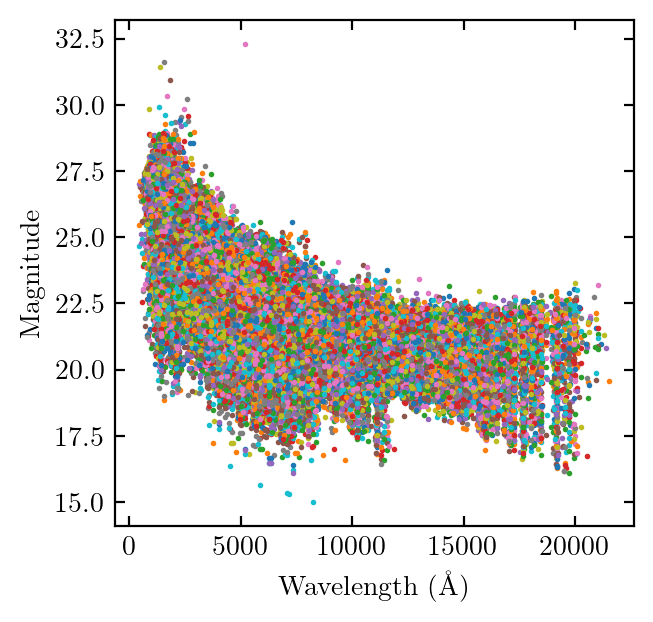

In [10]:
%%time
for galaxy in galaxies:
    plt.scatter(galaxy.wavelen/(1+galaxy.redshift),galaxy.mags,s=1)

plt.xlabel("Wavelength ($\mathrm{\AA}$)")
plt.ylabel("Magnitude")
plt.show()

Redshift histogram per catalog

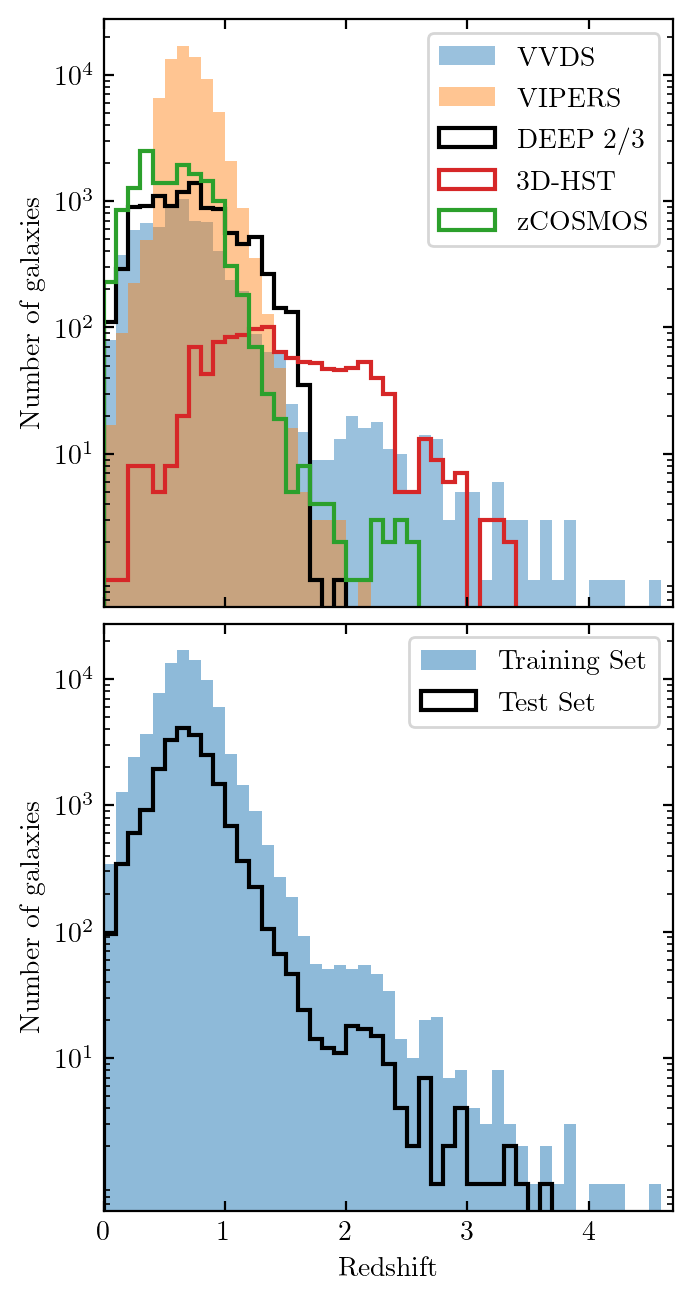

In [30]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,sharey=True,figsize=(onecol,0.9*twocol),constrained_layout=True)
fig.set_constrained_layout_pads(hspace=0)

deep_redshifts = [galaxy.redshift for galaxy in deep_galaxies]
hst_redshifts = [galaxy.redshift for galaxy in hst_galaxies]
cosmos_redshifts = [galaxy.redshift for galaxy in cosmos_galaxies]
vvds_redshifts = [galaxy.redshift for galaxy in vvds_galaxies]
vipers_redshifts = [galaxy.redshift for galaxy in vipers_galaxies]
training_redshifts = [galaxy.redshift for galaxy in training_galaxies]
test_redshifts = [galaxy.redshift for galaxy in test_galaxies]

zmax = 4.6
nbins = int(10*zmax)
ax1.hist(vvds_redshifts,range=(0,zmax),bins=nbins,label='VVDS',histtype='stepfilled',color='C0',alpha=0.45)
ax1.hist(vipers_redshifts,range=(0,zmax),bins=nbins,label='VIPERS',histtype='stepfilled',color='C1',alpha=0.45)
ax1.hist(deep_redshifts,range=(0,zmax),bins=nbins,label='DEEP 2/3',histtype='step',color='k',lw=1.5)
ax1.hist(hst_redshifts,range=(0,zmax),bins=nbins,label='3D-HST',histtype='step',color='C3',lw=1.5)
ax1.hist(cosmos_redshifts,range=(0,zmax),bins=nbins,label='zCOSMOS',histtype='step',color='C2',lw=1.5)

ax2.hist(training_redshifts,range=(0,zmax),bins=nbins,label='Training Set',histtype='stepfilled',color='C0',alpha=0.5)
ax2.hist(test_redshifts,range=(0,zmax),bins=nbins,label='Test Set',histtype='step',color='k',lw=1.5)

ax1.legend()
ax2.legend()

ax2.set_xlim(0,zmax+0.1)
ax2.set_xlabel('Redshift')
ax1.set_ylabel('Number of galaxies')
ax2.set_ylabel('Number of galaxies')
ax1.set_yscale('log')
ax1.set_yticks([10,100,1000,10000])
plt.show()

#fig.savefig('plots/redshift_distribution.pdf')


Redshift histogram per i-band magnitude

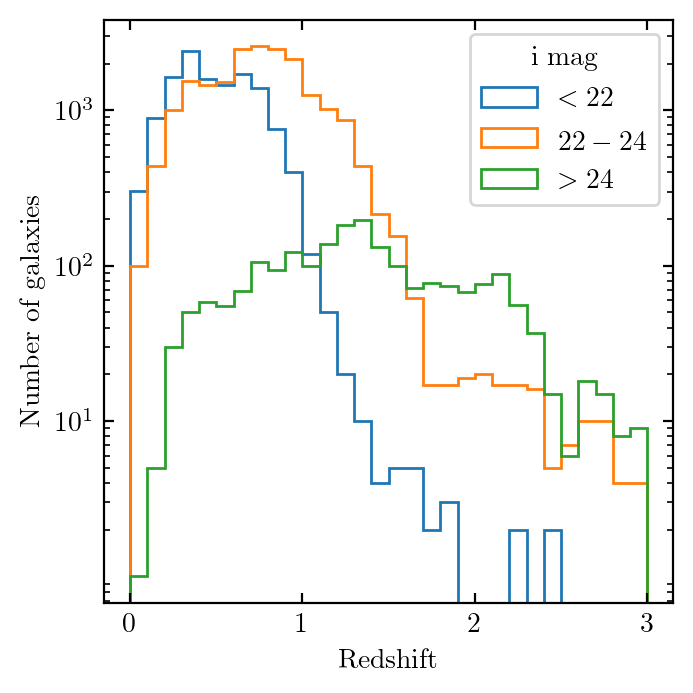

In [48]:
fig,ax = plt.subplots(constrained_layout=True)

redshifts = np.array([])
imags = np.array([])
for galaxy in galaxies:
    if 'i' in galaxy.filters:
        redshifts = np.append(redshifts,galaxy.redshift)
        idx = np.where(galaxy.filters == 'i')
        imags = np.append(imags,galaxy.mags[idx])
        
idx = np.where( imags <= 22 )
ax.hist(redshifts[idx],range=(0,3),bins=30,histtype='step',label='$<22$')
idx = np.where( ( imags > 22 ) & ( imags <= 24 ) )
ax.hist(redshifts[idx],range=(0,3),bins=30,histtype='step',label='$22-24$')
idx = np.where( imags > 24 )
ax.hist(redshifts[idx],range=(0,3),bins=30,histtype='step',label='$>24$')

ax.legend(title='i mag')

ax.set_xlabel('Redshift')
ax.set_ylabel('Number of galaxies')
ax.set_yscale('log')
ax.set_yticks([10,100,1000])

plt.show()